# Evaluations against the MNIST dataset

## Setup 

### Handle Imports

In [1]:
import os
import sys

sys.path.append("../../src")

import copy
import pickle
import random
from time import time

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from alibi.explainers import Counterfactual, CounterfactualProto
from keras.layers import Dropout  # type: ignore
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, UpSampling2D
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.ndimage import gaussian_filter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVR
from tensorflow.keras.models import Model, load_model  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore
from tqdm import tqdm

from tuneable_counterfactuals_explainer.explainer import Explainer
from tuneable_counterfactuals_explainer.single_variable_explainer import (
    SingleVariableExplainer,
)

tf.get_logger().setLevel(40)  # suppress deprecation messages
tf.compat.v1.disable_v2_behavior()  # disable TF2 behavior as alibi code still relies on TF1 constructs

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-14 21:46:24,970	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Create and Train Model

In [2]:
# Get MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Filter to only 0s and 1s
x_train = x_train[(y_train == 0) | (y_train == 1)]
y_train = y_train[(y_train == 0) | (y_train == 1)]
x_test = x_test[(y_test == 0) | (y_test == 1)]
y_test = y_test[(y_test == 0) | (y_test == 1)]

# Reshape and normalize
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))

# One-hot encode labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Set Data Range
xmin, xmax = -0.5, 0.5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (
    xmax - xmin
) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (
    xmax - xmin
) + xmin


# Define Model
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=64, kernel_size=2, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x_out = Dense(2, activation="softmax")(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return cnn


clf = KerasRegressor(build_fn=cnn_model, epochs=5, batch_size=32, verbose=1)
sklearn_pipeline = Pipeline([("clf", clf)])
keras.utils.set_random_seed(0)
sklearn_pipeline.fit(x_train, y_train)

cnn = sklearn_pipeline[0].model

# Evaluate Model
score = cnn.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: ", score[1])

x_train shape: (60000, 28, 28) y_train shape: (60000,)
Train on 12665 samples
Epoch 1/5
   32/12665 [..............................] - ETA: 17s - loss: 0.6736 - acc: 0.5625

/var/folders/qx/p1n3nbvn2j55yp0mkrpbgngr0000gn/T/ipykernel_10064/1981709028.py:52: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasRegressor(build_fn=cnn_model, epochs=5, batch_size=32, verbose=1)
2024-07-14 21:46:25.641517: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-07-14 21:46:25.654254: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/conv2d/kernel/m/Assign' id:384 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d/kernel/m, training/Adam/conv2d/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an erro

12665/12665 [==============================] - 2s 161us/sample - loss: 0.0430 - acc: 0.9867
Epoch 2/5
12665/12665 [==============================] - 3s 205us/sample - loss: 0.0057 - acc: 0.9980
Epoch 3/5
12665/12665 [==============================] - 2s 179us/sample - loss: 0.0049 - acc: 0.9988
Epoch 4/5
12665/12665 [==============================] - 2s 195us/sample - loss: 0.0034 - acc: 0.9987
Epoch 5/5
12665/12665 [==============================] - 2s 197us/sample - loss: 0.0044 - acc: 0.9986
Test accuracy:  1.0


/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-07-14 21:46:37.552621: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:195 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [3]:
def predict_class(x):
    return cnn.predict(x).argmax(axis=1)[0]

## Baseline Methodology

### Setup Explainer Object 

In [4]:
cf_baseline = Counterfactual(
    cnn,
    shape=(1,) + x_train.shape[1:],
    feature_range=(-0.5, 0.5),
)

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-07-14 21:46:37.874289: W tensorflow/c/c_api.cc:305] Operation '{name:'dense/Softmax' id:119 op device:{requested: '', assigned: ''} def:{{{node dense/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Run Single Example

In [5]:
res_baseline = cf_baseline.explain(x_train[0].reshape(1, 28, 28, 1))

### Do Plot

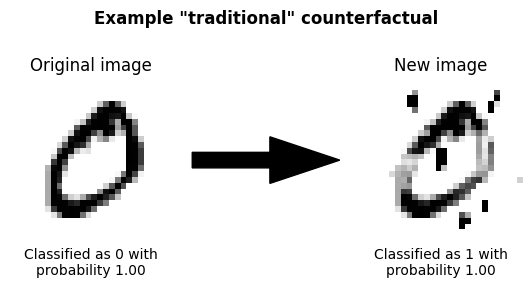

In [6]:
fig, axs = plt.subplots(1, 3)
plt.suptitle('Example "traditional" counterfactual', weight="bold")

# Plot the first image
axs[0].imshow(
    np.array(x_train[0]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
axs[0].set_title("Original image")
axs[0].set_xlabel(
    f"Classified as {predict_class(x_train[0].reshape(1, 28,28,1))} with\nprobability {cnn.predict(x_train[0].reshape(1, 28,28,1)).max():.2f}"
)

# Add an arrow between the two images
axs[1].arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="k")
axs[1].set_ylim([0, 1])

# Plot the second image
final = res_baseline.cf["X"].reshape(28, 28)
axs[2].imshow(np.array(final).astype(np.float32).reshape(28, 28), cmap="binary")
axs[2].set_title(
    "New image",
)
axs[2].set_xlabel(
    f'Classified as {predict_class(res_baseline.cf["X"])} with\nprobability {cnn.predict(res_baseline.cf["X"]).max():.2f}'
)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_aspect("equal")

plt.tight_layout()
fig.subplots_adjust(top=1.3)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(left=0.1)
plt.savefig("../../figures/mnist_counterfactual_trad_example.eps", bbox_inches="tight")
plt.show()

## Prototype Methodology 

### Setup AutoEncoder

In [7]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation="relu", padding="same")(x_in)
    x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2), padding="same")(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding="same")(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation="relu", padding="same")(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding="same")(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer="adam", loss="mse")

    return autoencoder, encoder, decoder


ae, enc, dec = ae_model()
ae.fit(
    x_train,
    x_train,
    batch_size=128,
    epochs=4,
    validation_data=(x_test, x_test),
    verbose=0,
)

2024-07-14 21:46:40.830485: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/conv2d_3/kernel/v/Assign' id:1287 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/conv2d_3/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/conv2d_3/kernel/v, training_2/Adam/conv2d_3/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-07-14 21:46:45.099592: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:1085 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/model_2_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an err

### Setup Explainer Object

In [8]:
shape = (1,) + x_train.shape[1:]
gamma = 100.0
theta = 100.0
c_init = 1.0
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(), x_train.max())

cf_prototype = CounterfactualProto(
    cnn,
    shape,
    gamma=gamma,
    theta=theta,
    ae_model=ae,
    enc_model=enc,
    max_iterations=max_iterations,
    feature_range=feature_range,
    c_init=c_init,
    c_steps=c_steps,
)
cf_prototype.fit(x_train)

2024-07-14 21:46:58.222870: W tensorflow/c/c_api.cc:305] Operation '{name:'conv2d_4/BiasAdd' id:967 op device:{requested: '', assigned: ''} def:{{{node conv2d_4/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](conv2d_4/Conv2D, conv2d_4/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 28, 28, 1),
              'kappa': 0.0,
              'beta': 0.1,
              'feature_range': (-0.5, 0.5),
              'gamma': 100.0,
              'theta': 100.0,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': False,
              'learning_rate_init': 0.01,
              'max_iterations': 1000,
              'c_init': 1.0,
              'c_steps': 2,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'is_model': True,
              'is_ae': True,
              'is_enc': True,
              'enc_or_kdtree': True,
              'is_cat': False,
              'trustscore_kwargs': None,
              'd_type': 'abdm',
              'w': None,
              'd

### Run Single Example

In [9]:
res_prototype = cf_prototype.explain(x_train[1].reshape(1, 28, 28, 1))

2024-07-14 21:46:59.625775: W tensorflow/c/c_api.cc:305] Operation '{name:'adv/Assign' id:1438 op device:{requested: '', assigned: ''} def:{{{node adv/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@adv"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](adv, adv/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Do Plot

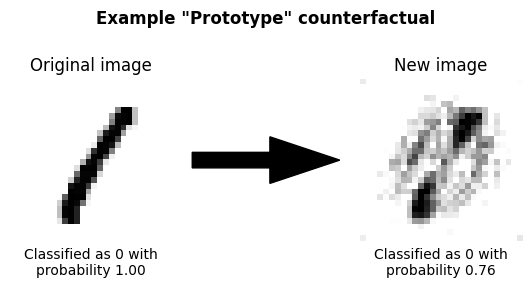

In [10]:
fig, axs = plt.subplots(1, 3)
plt.suptitle('Example "Prototype" counterfactual', weight="bold")

# Plot the first image
axs[0].imshow(
    np.array(x_train[1]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
axs[0].set_title("Original image")
axs[0].set_xlabel(
    f"Classified as {predict_class(x_train[0].reshape(1, 28,28,1))} with\nprobability {cnn.predict(x_train[0].reshape(1, 28,28,1)).max():.2f}"
)

# Add an arrow between the two images
axs[1].arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="k")
axs[1].set_ylim([0, 1])

# Plot the second image
final = res_prototype.cf["X"].reshape(28, 28)
axs[2].imshow(np.array(final).astype(np.float32).reshape(28, 28), cmap="binary")
axs[2].set_title(
    "New image",
)
axs[2].set_xlabel(
    f'Classified as {predict_class(res_prototype.cf["X"])} with\nprobability {cnn.predict(res_prototype.cf["X"]).max():.2f}'
)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_aspect("equal")

plt.tight_layout()
fig.subplots_adjust(top=1.3)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(left=0.1)
plt.savefig("../../figures/mnist_counterfactual_proto_example.eps", bbox_inches="tight")
plt.show()

## Novel Counterfactuals

### Setup Modified Model with Reshape Layer

In [11]:
pipeline_with_reshape = copy.copy(sklearn_pipeline)
pipeline_with_reshape.steps.insert(
    0, ("reshape", FunctionTransformer(lambda x: x.values.reshape(-1, 28, 28, 1)))
)
df = pd.DataFrame(x_train.reshape(-1, 28 * 28))
df.columns = [f"pixel_{i}" for i in range(28 * 28)]
df["target"] = y_train[:, 1]
pipeline_with_reshape[0].feature_names_in_ = df.columns[:-1]

### Setup Explainer Object

In [12]:
explainer = Explainer(
    pipeline_with_reshape,
    df,
    "target",
    regressor="linear",
    bounding_method="quantile",
    probability_prediction_function=lambda x: pipeline_with_reshape.predict(x).reshape(
        -1, 2
    ),
    class_prediction_function=lambda x: (pipeline_with_reshape.predict(x).argmax()),
)

### Run Stepped Example

In [13]:
results = []
for additional_threshold in [-0.25, 0, 0.4999999]:
    results.append(
        explainer.explain(
            df.iloc[1],
            additional_threshold=additional_threshold,
            store_historical_times=True,
        )
    )

  5%|▍         | 36/784 [01:55<40:00,  3.21s/it]


### Run "Many" Examples

In [14]:
many_results = []
for i in range(2, 10):
    many_results.append(
        (
            df.iloc[i],
            explainer.explain(
                df.iloc[i],
                additional_threshold=0.4999,
                store_historical_times=True,
            ),
        )
    )

 11%|█         | 85/784 [03:54<32:09,  2.76s/it]


### Plotting Helper Functions

In [51]:
def plot_with_changes_highlighted(
    ax, original, result_object, initial_classification, fontsize=36
):
    new = result_object[1].explanation_point

    new[result_object[1].explainable_variable] = result_object[1].get_arg_extrema(
        initial_classification=initial_classification
    )
    new = np.array(new).astype(np.float32)

    if type(original) is not np.ndarray:
        original = np.array(original).astype(np.float32)

    new_unchanged = new.copy()
    new_larger = new.copy()
    new_smaller = new.copy()

    new_unchanged[original != new] = np.nan  # Only plot if it's the same
    new_larger[original >= new] = np.nan  # Only plot if it's larger
    new_smaller[original <= new] = np.nan  # Only plot if it's smaller

    ax.imshow(
        np.array(new_unchanged[:-1]).reshape(28, 28), cmap="binary", vmin=-0.5, vmax=0.5
    )

    ax.imshow(
        np.array(new_larger[:-1]).reshape(28, 28), cmap="Greens", vmin=-0.5, vmax=0.5
    )

    ax.imshow(
        np.array(new_smaller[:-1]).reshape(28, 28), cmap="Reds", vmin=-0.5, vmax=0.5
    )

    def highlight_cell(x, y, ax, color):
        ax.add_patch(
            plt.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=False, edgecolor=color, lw=2)
        )

    for i in range(28):
        for j in range(28):
            if not np.isnan(new_larger[i * 28 + j]):
                highlight_cell(j, i, ax, "g")
            if not np.isnan(new_smaller[i * 28 + j]):
                highlight_cell(j, i, ax, "r")

    ax.set_xlabel(
        f"Classified as {result_object[1].class_prediction_function(pd.DataFrame(new[:-1]).T)} with\nprobability {result_object[1].probability_prediction_function(pd.DataFrame(new[:-1]).T).max():.5f}",
        fontsize=fontsize,
    )

    return new


def plot_arrow(ax):
    ax.arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="k")
    ax.set_ylim([0, 1])

### Plotting Results

#### Many Results Example

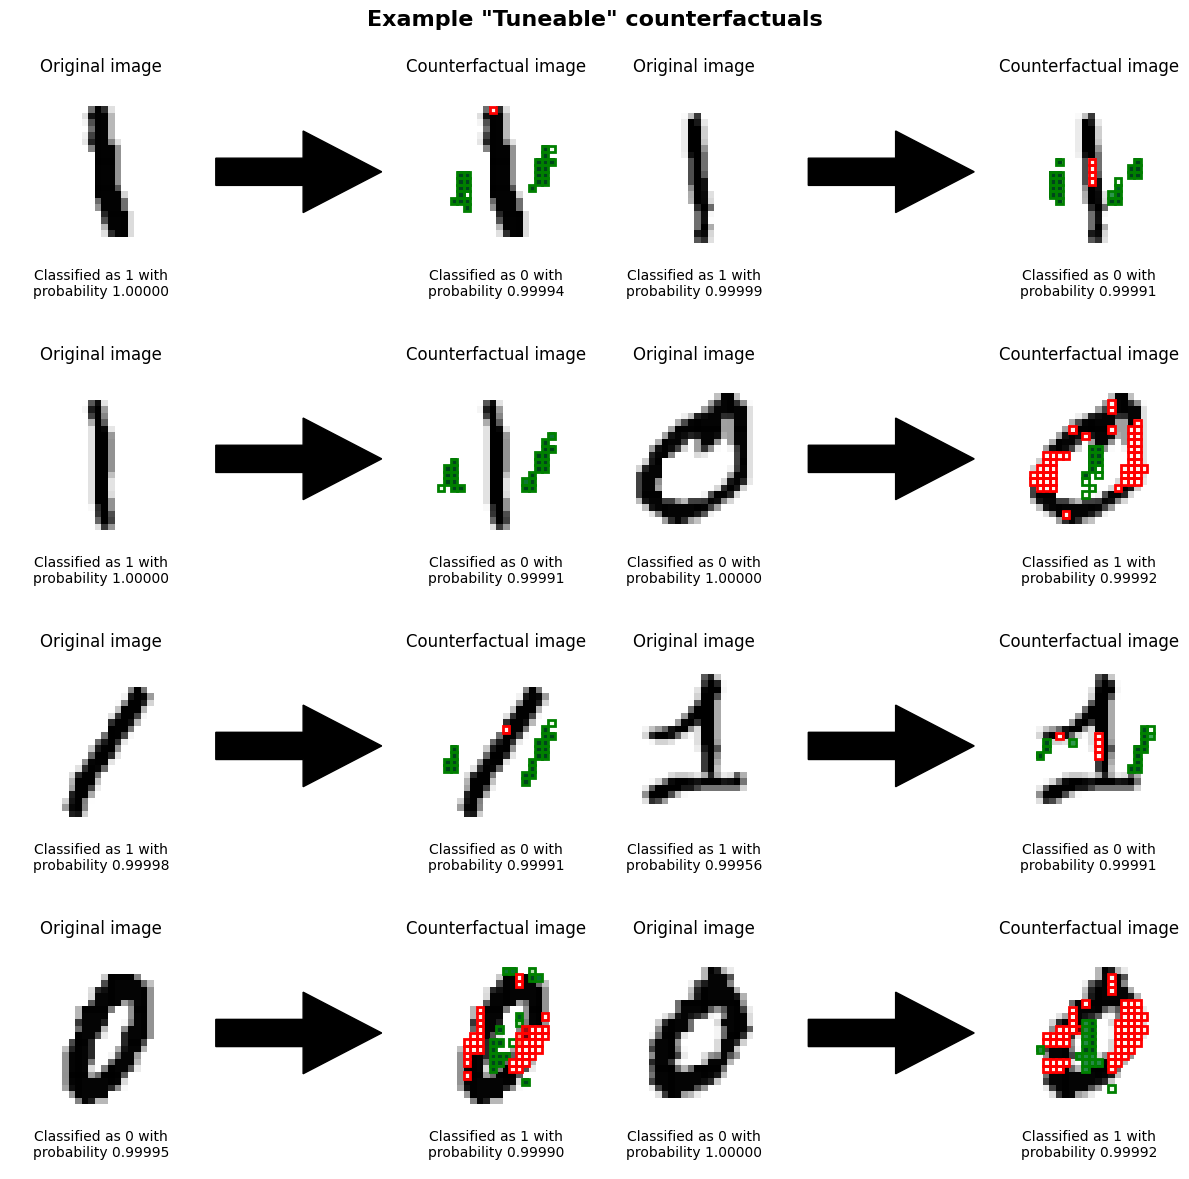

In [16]:
fig, axs = plt.subplots(4, 6, figsize=(12, 12))
plt.suptitle('Example "Tuneable" counterfactuals', weight="bold", fontsize=16)

for i, (initial, result) in enumerate(many_results):
    row_index = int(i / 2)
    col_index = 3 * (i % 2)
    axs[row_index, col_index].imshow(
        np.array(initial[:-1]).astype(np.float32).reshape(28, 28),
        cmap="binary",
    )
    axs[row_index, col_index].set_title("Original image")
    axs[row_index, col_index].set_xlabel(
        f"Classified as {result[1].class_prediction_function(pd.DataFrame(initial[:-1]).T)} with\nprobability {result[1].probability_prediction_function(pd.DataFrame(initial[:-1]).T).max():.5f}",
    )

    plot_with_changes_highlighted(
        axs[row_index, col_index + 2],
        initial,
        result,
        initial_classification=result[1].class_prediction_function(
            pd.DataFrame(initial[:-1]).T
        ),
        fontsize=None,
    )
    axs[row_index, col_index + 2].set_title("Counterfactual image")
    axs[row_index, col_index].set_xticks([])
    axs[row_index, col_index].set_yticks([])
    axs[row_index, col_index + 2].set_xticks([])
    axs[row_index, col_index + 2].set_yticks([])
    axs[row_index, col_index + 1].axis("off")

    # Set border to white
    for ax in [axs[row_index, col_index], axs[row_index, col_index + 2]]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)

    # Draw arrows between the plots
    plot_arrow(axs[row_index, col_index + 1])

plt.tight_layout()
plt.savefig(
    "../../figures/mnist_counterfactual_tuneable_example_many.eps", bbox_inches="tight"
)

#### Step-by-Step Example

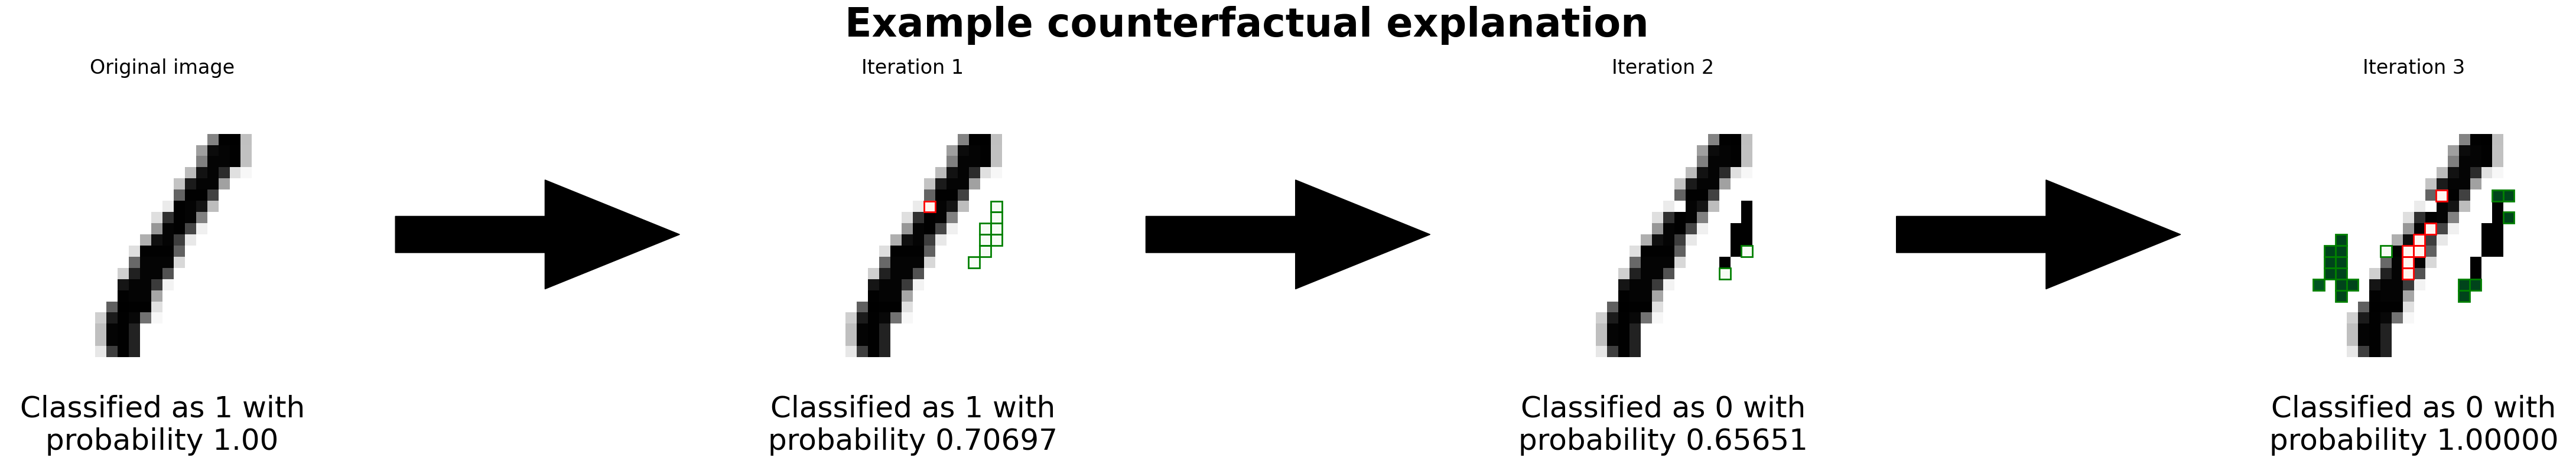

In [17]:
n = len(results)
subplots = 2 * n + 1
res = 8
fig, axs = plt.subplots(1, subplots, figsize=(res * subplots, res))
plt.suptitle("Example counterfactual explanation\n\n", weight="bold", fontsize=48)

initial_classification = results[0][1].class_prediction_function(
    pd.DataFrame(np.array(df.iloc[1]).astype(np.float32)[:-1]).T
)

axs[0].imshow(
    np.array(df.iloc[1][:-1]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
axs[0].set_title("Original image", fontsize=24)
axs[0].set_xlabel(
    f"Classified as {initial_classification} with\nprobability {results[0][1].probability_prediction_function(pd.DataFrame(np.array(df.iloc[1]).astype(np.float32)[:-1]).T).max():.2f}",
    fontsize=36,
)

axs[0].set_xticks([])
axs[0].set_yticks([])
for spine in axs[0].spines:
    axs[0].spines[spine].set_visible(False)

working_new = df.iloc[1]
for i in range(1, subplots - 1, 2):
    plot_arrow(axs[i])
    working_new = plot_with_changes_highlighted(
        axs[i + 1],
        working_new,
        results[i // 2],
        initial_classification=initial_classification,
    )
    axs[i + 1].set_title(f"Iteration {i//2 + 1}", fontsize=24)
    for ax in [axs[i], axs[i + 1]]:
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)

plt.savefig("../../figures/mnist_counterfactual_example.eps", bbox_inches="tight")
plt.savefig("../../figures/mnist_counterfactual_example.png", bbox_inches="tight")

#### Generation Statistics Plot 

In [18]:
overall_result = results[-1]

In [19]:
initial_point = df.iloc[1][:-1]
initial_classification = int(
    results[0][1].class_prediction_function(pd.DataFrame(initial_point).T)
)
working_point = initial_point.copy()
probabilities = [
    results[0][1].probability_prediction_function(pd.DataFrame(initial_point).T)[:, 1]
]
for feature in overall_result[0]:
    sve = SingleVariableExplainer(
        pipeline_with_reshape,
        "target",
        feature,
        working_point,
        training_dataset=df,
        regressor="linear",
        bounding_method="quantile",
        class_prediction_function=lambda x: pipeline_with_reshape.predict(x).argmax(),
        probability_prediction_function=lambda x: pipeline_with_reshape.predict(
            x
        ).reshape(-1, 2),
    )
    working_point[feature] = sve.get_arg_extrema(
        initial_classification=initial_classification
    )
    probabilities.append(
        results[0][1].probability_prediction_function(pd.DataFrame(working_point).T)[
            :, 1
        ]
    )

probabilities = [(1 - x[0]) for x in probabilities]
step_time = pd.DataFrame(overall_result[-1]).diff().values.flatten()
scores = overall_result[3]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


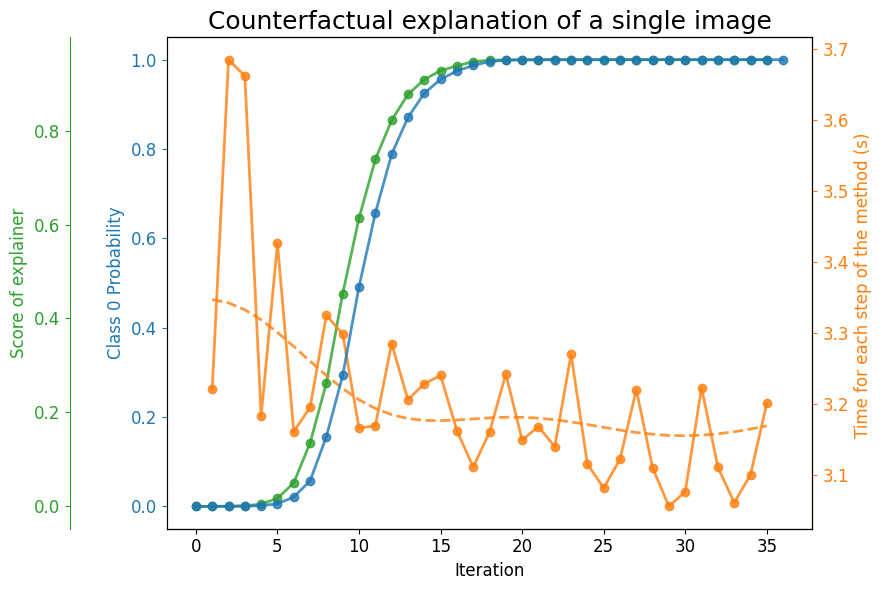

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(probabilities, "o-", linewidth=2, markersize=6, color="C0", alpha=0.8)

twin_ax = ax.twinx()
twin_ax.plot(step_time, "o-", linewidth=2, markersize=6, color="C1", alpha=0.8)

twin_ax_2 = ax.twinx()
twin_ax_2.plot(scores, "o-", linewidth=2, markersize=6, color="C2", alpha=0.8)

twin_ax_2.spines["left"].set_position(("axes", -0.15))
twin_ax_2.spines["left"].set_visible(True)

twin_ax_2.yaxis.set_label_position("left")
twin_ax_2.yaxis.set_ticks_position("left")

ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Class 0 Probability", fontsize=12)
twin_ax.set_ylabel("Time for each step of the method (s) ", fontsize=12)
twin_ax_2.set_ylabel("Score of explainer", fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=12)
twin_ax.tick_params(axis="both", which="major", labelsize=12)
twin_ax_2.tick_params(axis="both", which="major", labelsize=12)

fit_train_x = np.arange(len(step_time[1:]))
fit_train_y = step_time[1:]

gpr = SVR()
gpr.fit(fit_train_x.reshape(-1, 1), fit_train_y)
gpr_y_pred = gpr.predict(fit_train_x.reshape(-1, 1))

twin_ax.plot(fit_train_x + 1, gpr_y_pred, "--", linewidth=2, color="C1", alpha=0.8)

twin_ax.spines["left"].set_color("C0")
twin_ax.spines["right"].set_color("C1")
ax.yaxis.label.set_color("C0")
ax.tick_params(axis="y", colors="C0")
twin_ax.yaxis.label.set_color("C1")
twin_ax.tick_params(axis="y", colors="C1")
twin_ax_2.spines["left"].set_color("C2")
twin_ax_2.yaxis.label.set_color("C2")
twin_ax_2.tick_params(axis="y", colors="C2")

ax.set_zorder(twin_ax_2.get_zorder() + 2)
twin_ax.set_zorder(twin_ax_2.get_zorder() + 1)
ax.set_facecolor("none")

ax.set_title("Counterfactual explanation of a single image", fontsize=18)
plt.tight_layout()
plt.savefig(
    "../../figures/mnist_counterfactual_example_time_scores.eps", bbox_inches="tight"
)

#### Overall Single Example

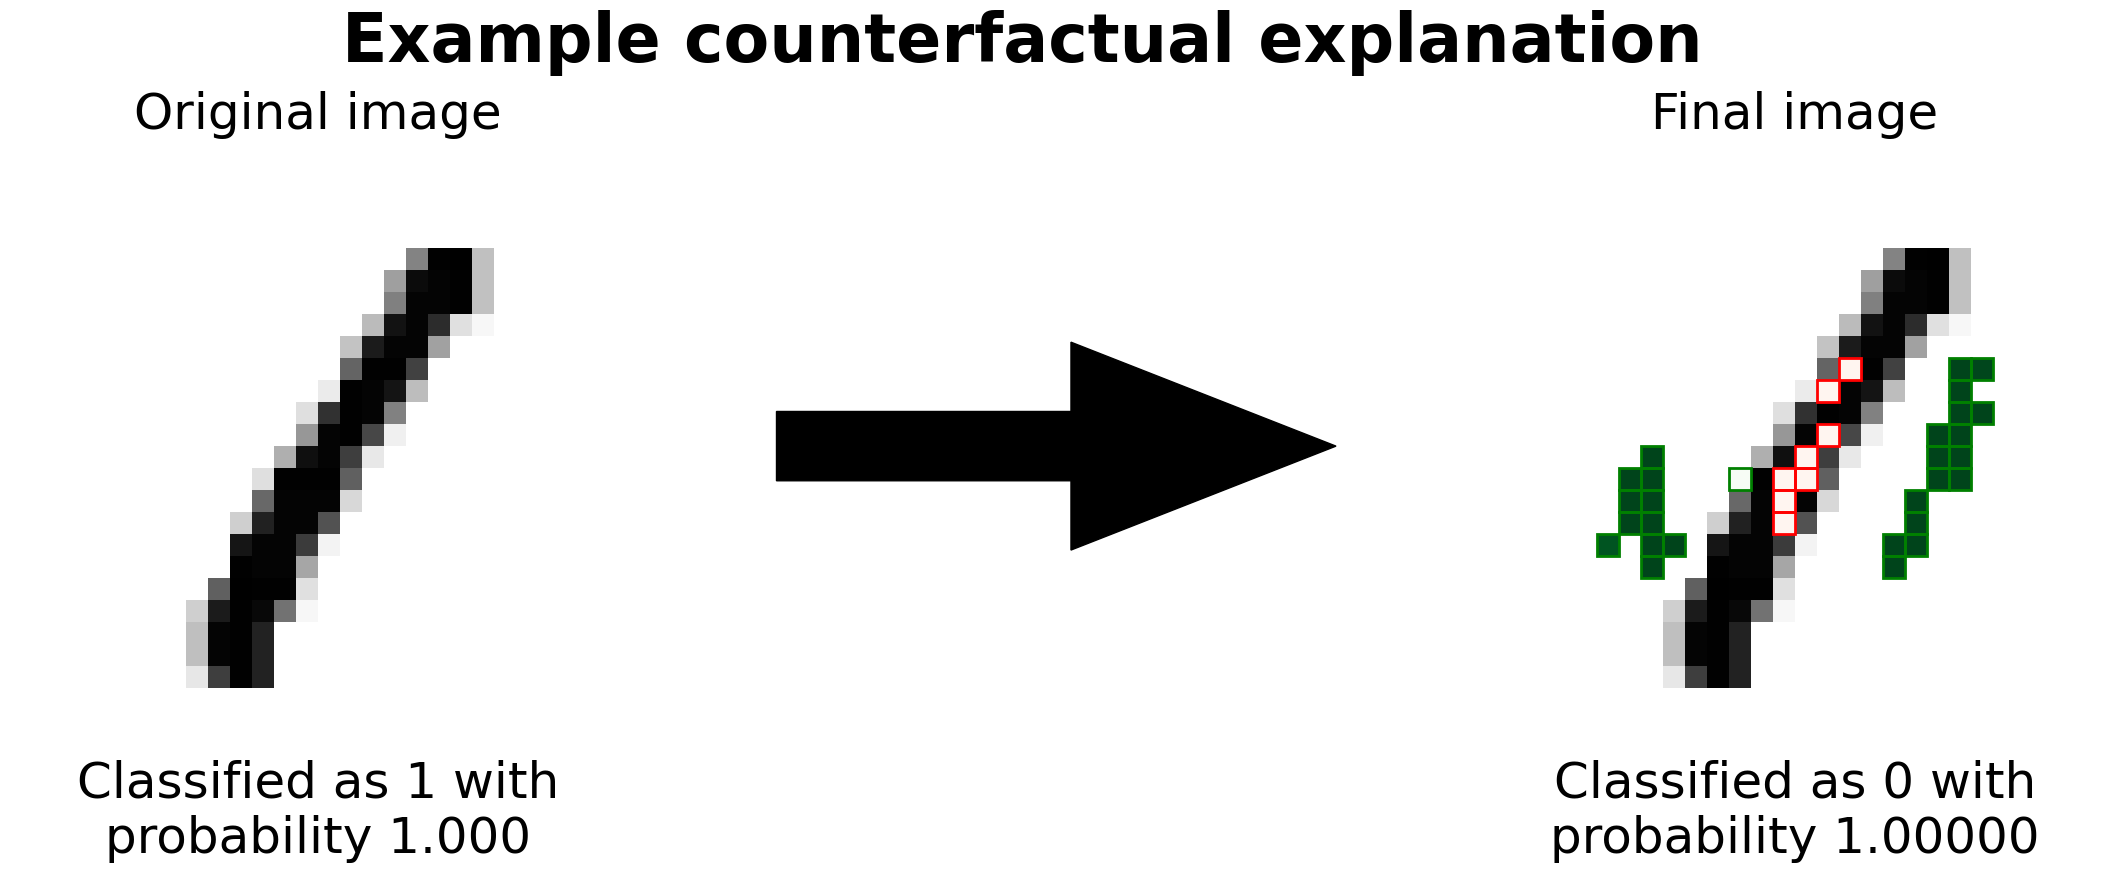

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(27, 9))
ax[0].imshow(
    np.array(df.iloc[1][:-1]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
ax[0].set_title("Original image", fontsize=36)
ax[0].set_xlabel(
    f"Classified as {pipeline_with_reshape.predict(df.iloc[1][:-1]).argmax()} with\nprobability {pipeline_with_reshape.predict(df.iloc[1][:-1]).reshape(-1, 2).max():.3f}",
    fontsize=36,
)

plot_arrow(ax[1])
_ = plot_with_changes_highlighted(
    ax[2],
    df.iloc[1],
    overall_result,
    initial_classification=pipeline_with_reshape.predict(df.iloc[1][:-1]).argmax(),
)
ax[2].set_title("Final image", fontsize=36)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    for spine in a.spines:
        a.spines[spine].set_visible(False)

plt.suptitle("Example counterfactual explanation\n\n", weight="bold", fontsize=48)

plt.savefig(
    "../../figures/overall_mnist_counterfactual_example.eps", bbox_inches="tight"
)
plt.savefig(
    "../../figures/overall_mnist_counterfactual_example.png", bbox_inches="tight"
)

### Scoring Functions

#### Setup Scores 

In [22]:
scores = gaussian_filter(
    ((df.iloc[1].values[:-1].astype(float).reshape(28, 28)) + 0.5), sigma=5
).reshape(784)
dict_scores = {x: y for x, y in zip(df.columns[:-1], scores) if y > 0.05}

#### Setup Explainer Object

In [23]:
explainer_scoring = Explainer(
    pipeline_with_reshape,
    df,
    "target",
    regressor="linear",
    bounding_method="minmax",
    changeability_scores=dict_scores,
    override_variable_bounds=(-0.5, 0.5),
    probability_prediction_function=lambda x: pipeline_with_reshape.predict(x).reshape(
        -1, 2
    ),
    class_prediction_function=lambda x: pipeline_with_reshape.predict(x).argmax(),
)

#### Generate the explanation

In [24]:
result_scoring = explainer_scoring.explain(
    df.iloc[1],
    additional_threshold=0.4999999,
    store_historical_times=True,
)

  8%|▊         | 38/492 [00:57<11:23,  1.51s/it]


#### Plot Results

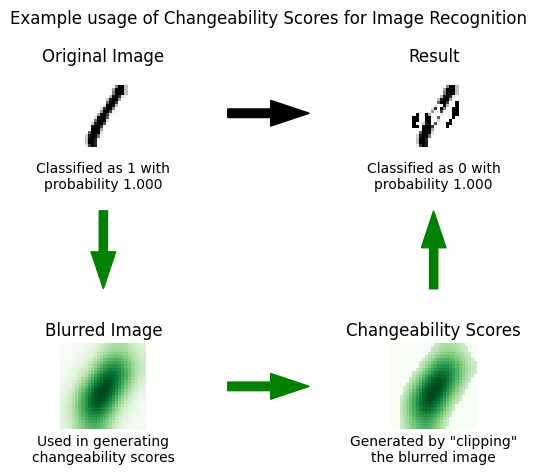

In [47]:
fig, axs = plt.subplots(3, 3)
plt.suptitle("Example usage of Changeability Scores for Image Recognition")

# Initial Image
axs[0, 0].imshow(
    np.array(df.iloc[1][:-1]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
axs[0, 0].set_title("Original Image")
axs[0, 0].set_xlabel(
    f"Classified as {pipeline_with_reshape.predict(df.iloc[2][:-1]).argmax()} with\nprobability {pipeline_with_reshape.predict(df.iloc[2][:-1]).reshape(-1, 2).max():.3f}"
)

# Blur Image
blurred = gaussian_filter(
    (np.array(df.iloc[1][:-1]).astype(np.float32).reshape(28, 28) + 0.5),
    sigma=5,
)
axs[2, 0].imshow(blurred, cmap="Greens")
axs[2, 0].set_title("Blurred Image")
axs[2, 0].set_xlabel("Used in generating\nchangeability scores")

# Changeability Scores
blurred[blurred <= 0.05] = 0
axs[2, 2].imshow(blurred, cmap="Greens")
axs[2, 2].set_title("Changeability Scores")
axs[2, 2].set_xlabel('Generated by "clipping"\nthe blurred image')

# Result
final = result_scoring[1].explanation_point
final[result_scoring[1].explainable_variable] = result_scoring[1].get_arg_extrema()
axs[0, 2].imshow(np.array(final[:-1]).astype(np.float32).reshape(28, 28), cmap="binary")
axs[0, 2].set_title("Result")
axs[0, 2].set_xlabel(
    f"Classified as {pipeline_with_reshape.predict(final[:-1]).argmax()} with\nprobability {pipeline_with_reshape.predict(final[:-1]).reshape(-1, 2).max():.3f}"
)

axs[0, 1].arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="k")
axs[0, 1].set_ylim([0, 1])

axs[2, 1].arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="green")
axs[2, 1].set_ylim([0, 1])

axs[1, 0].arrow(x=0.5, y=0.75, dx=0, dy=-0.5, width=0.1, color="green")
axs[1, 0].set_xlim([0, 1])

axs[1, 2].arrow(x=0.5, y=0.25, dx=0, dy=0.5, width=0.1, color="green")
axs[1, 2].set_xlim([0, 1])

for ax_t in axs:
    for ax in ax_t:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_aspect("equal")

plt.tight_layout()
# fig.subplots_adjust(top=1.5)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(left=0.1)

plt.savefig("../../figures/mnist_changeability_example.eps", bbox_inches="tight")
plt.show()

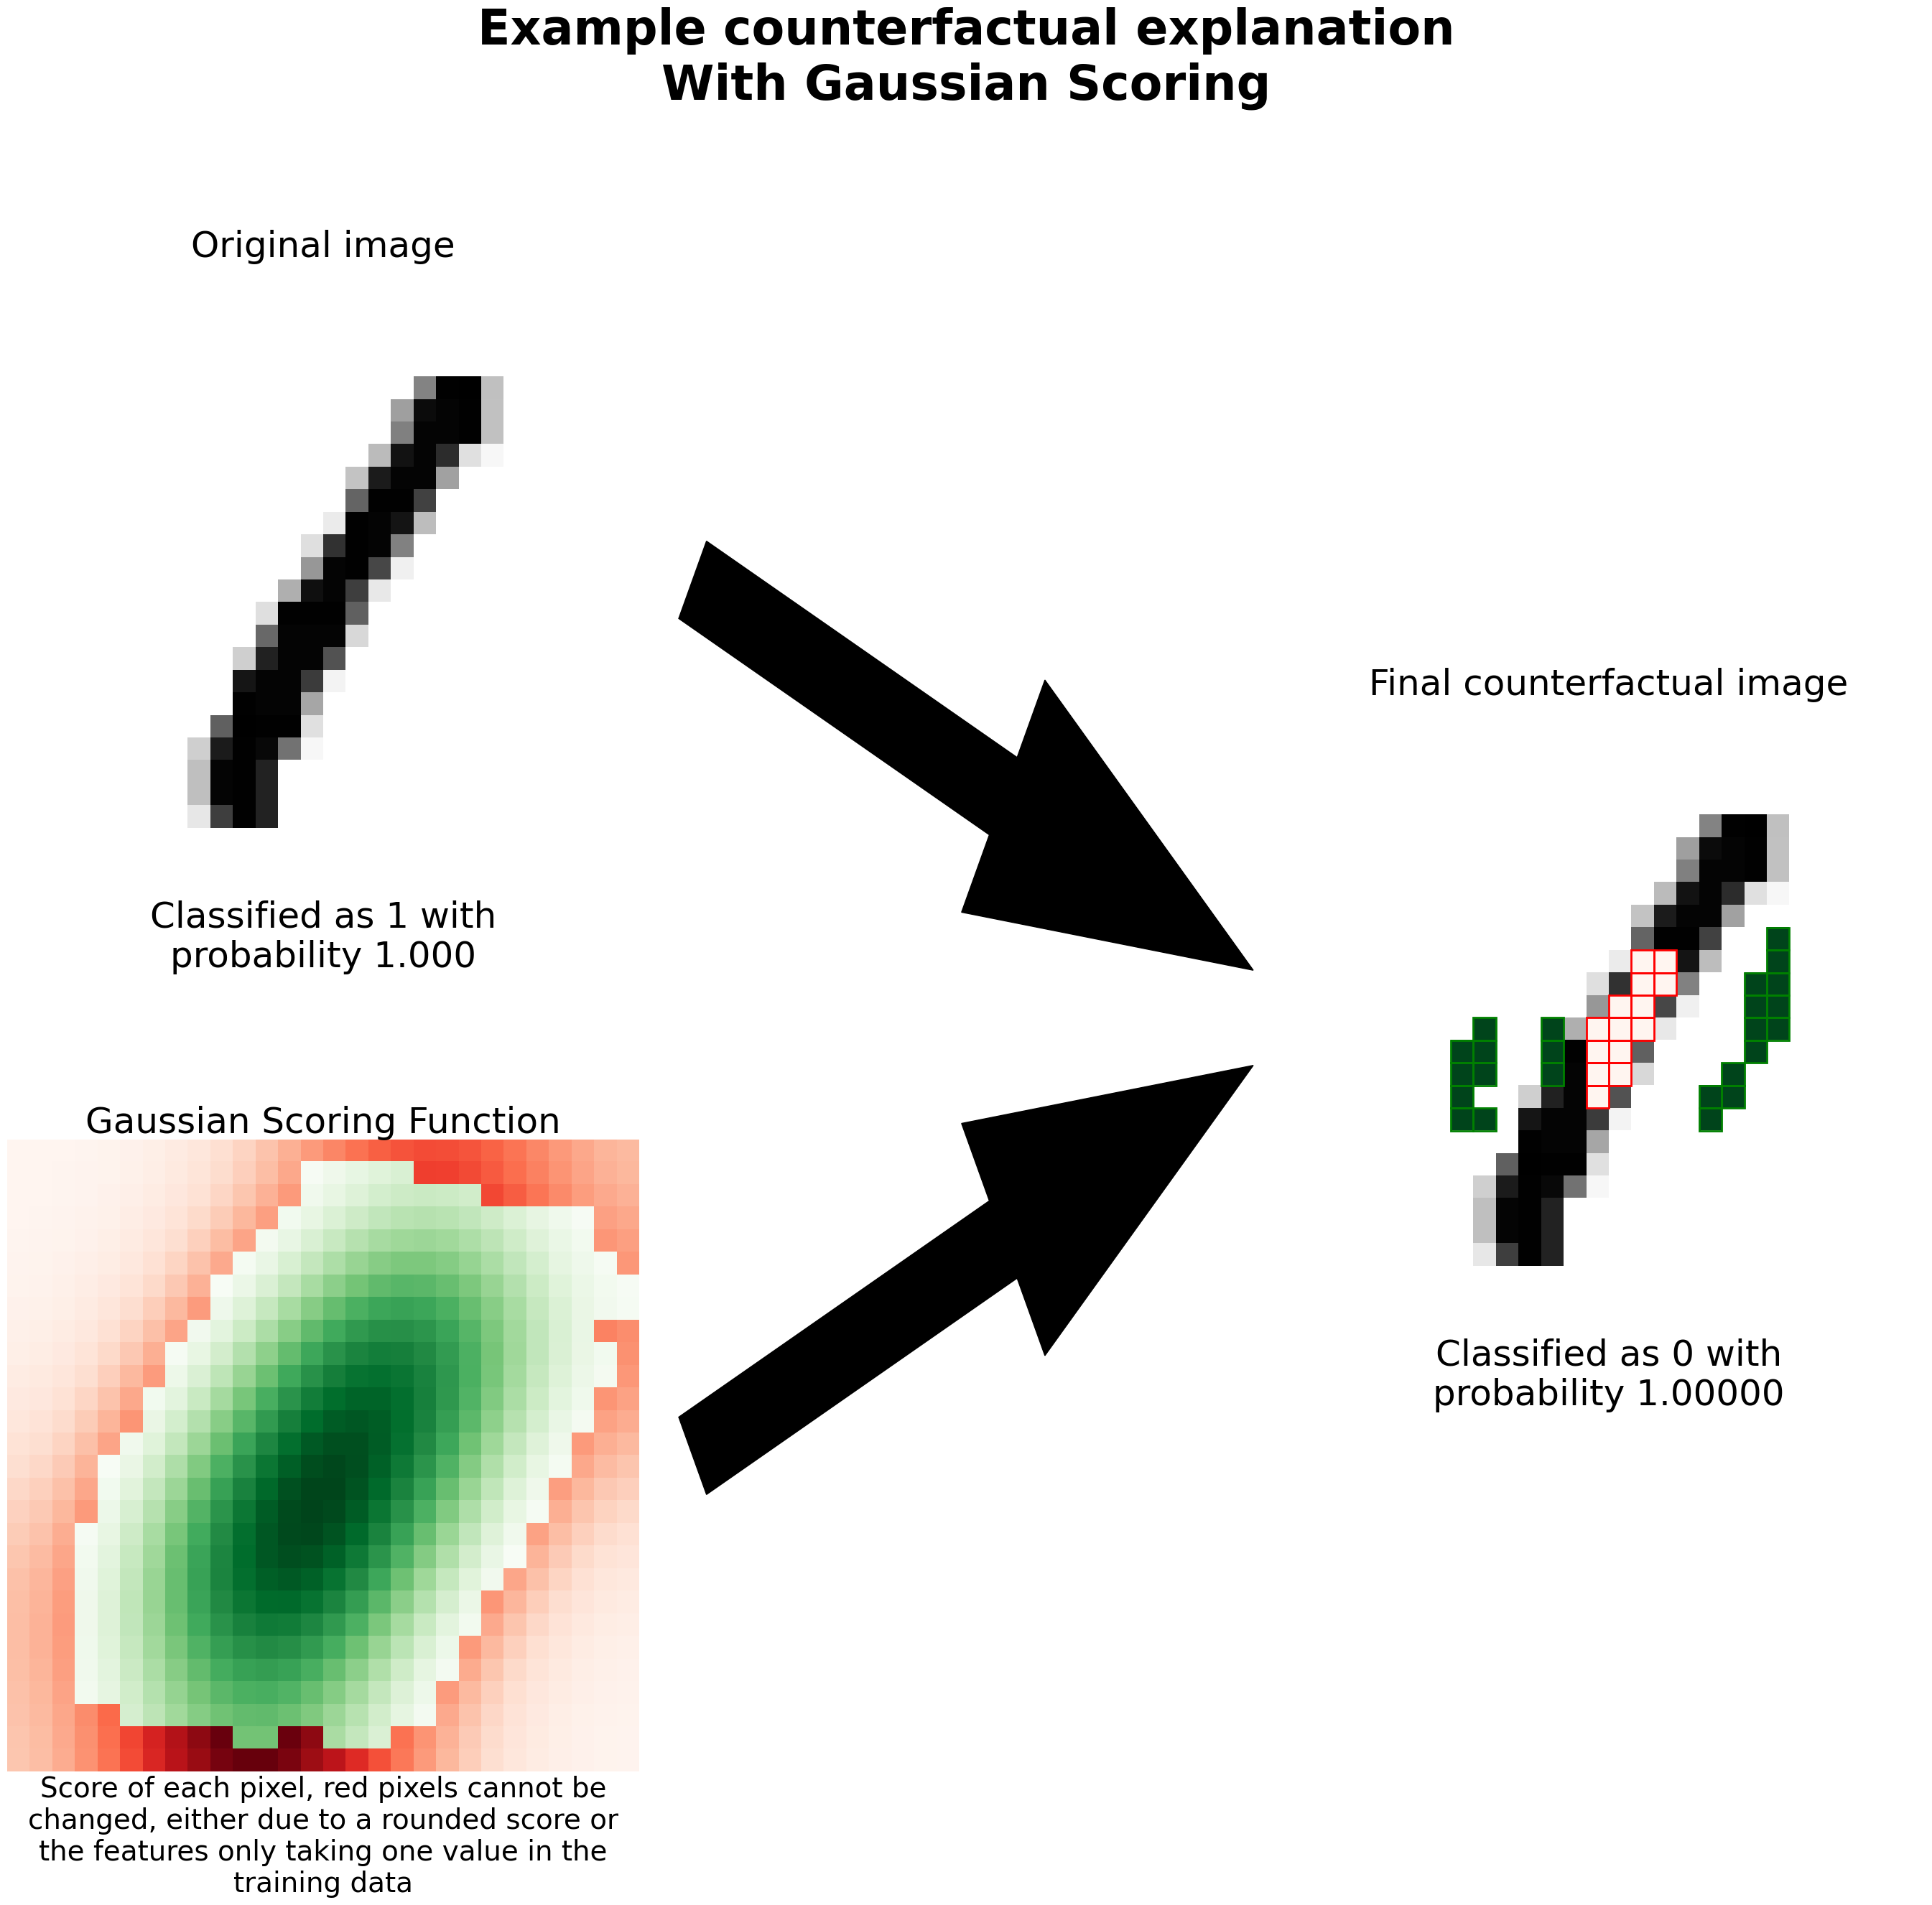

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(27, 27))
ax[0, 0].imshow(
    np.array(df.iloc[1][:-1]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
ax[0, 0].set_title("Original image", fontsize=36)
ax[0, 0].set_xlabel(
    f"Classified as {pipeline_with_reshape.predict(df.iloc[1][:-1]).argmax()} with\nprobability {pipeline_with_reshape.predict(df.iloc[1][:-1]).reshape(-1, 2).max():.3f}",
    fontsize=36,
)

blurred = gaussian_filter(
    np.array(df.iloc[1][:-1]).astype(np.float32).reshape(28, 28) + 0.5,
    sigma=5,
)

red_blurred = blurred.copy()
blurred[blurred <= 0.05] = np.nan
blurred[
    ((df.values.astype(float).max(axis=0) - df.values.astype(float).min(axis=0)) == 0)[
        :-1
    ].reshape(28, 28)
] = np.nan

red_blurred[
    ((df.values.astype(float).max(axis=0) - df.values.astype(float).min(axis=0)) != 0)[
        :-1
    ].reshape(28, 28)
    & (blurred > 0.05)
] = np.nan

ax[1, 0].imshow(blurred, cmap="Greens")
ax[1, 0].imshow(red_blurred, cmap="Reds")
ax[1, 0].set_title("Gaussian Scoring Function", fontsize=36)
ax[1, 0].set_xlabel(
    "Score of each pixel, red pixels cannot be\nchanged, either due to a rounded score or\nthe features only taking one value in the\ntraining data",
    fontsize=28,
)

gs = ax[1, 2].get_gridspec()
for a in ax[:, -1]:
    a.remove()
axbig = fig.add_subplot(gs[:, -1])

ax[1, 1].arrow(x=0.25, y=0.5, dx=0.5, dy=0.25, width=0.1, color="k")
ax[1, 1].set_ylim([0, 1])
ax[0, 1].arrow(x=0.25, y=0.5, dx=0.5, dy=-0.25, width=0.1, color="k")
ax[0, 1].set_ylim([0, 1])
_ = plot_with_changes_highlighted(
    axbig,
    df.iloc[1],
    result_scoring,
    initial_classification=pipeline_with_reshape.predict(df.iloc[1][:-1]).argmax(),
)
axbig.set_title("Final counterfactual image", fontsize=36)

for b in ax:
    for a in b:
        a.set_xticks([])
        a.set_yticks([])
        for spine in a.spines:
            a.spines[spine].set_visible(False)
for a in [axbig]:
    a.set_xticks([])
    a.set_yticks([])
    for spine in a.spines:
        a.spines[spine].set_visible(False)


plt.suptitle(
    "Example counterfactual explanation\nWith Gaussian Scoring\n",
    weight="bold",
    fontsize=48,
)
plt.tight_layout()
plt.savefig(
    "../../figures/overall_mnist_counterfactual_example.eps", bbox_inches="tight"
)
plt.savefig(
    "../../figures/overall_mnist_counterfactual_example.png", bbox_inches="tight"
)

## SHAP Explanations

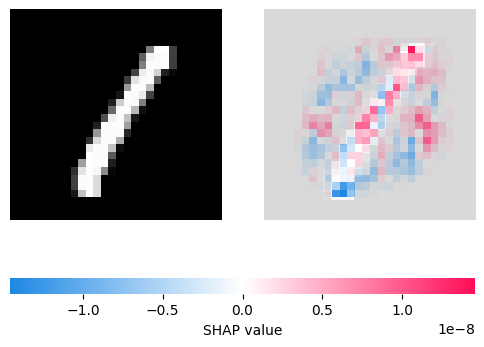

In [45]:
shap_explainer = shap.explainers.DeepExplainer(cnn, shap.sample(x_train, 1000))
shap_explanation = shap_explainer.shap_values(x_train[1].reshape(1, 28, 28, 1))
shap.image_plot(shap_explanation, x_train[1].reshape(1, 28, 28), show=False)
plt.savefig("../../figures/mnist_shap_example.png", bbox_inches="tight")

## Quantitative Evaluations

### Novel Method

In [28]:
explainer = Explainer(
    pipeline_with_reshape,
    df,
    "target",
    regressor="linear",
    bounding_method="quantile",
    probability_prediction_function=lambda x: pipeline_with_reshape.predict(x).reshape(
        -1, 2
    ),
    class_prediction_function=lambda x: (pipeline_with_reshape.predict(x).argmax()),
)

In [29]:
results_novel = {}
random.seed(0)
for i in tqdm(list(random.sample(range(len(df)), 50))):
    results_novel[i] = explainer.explain(df.iloc[i], additional_threshold=0.25)

100%|██████████| 50/50 [56:19<00:00, 67.60s/it]


In [30]:
to_eval = list(results_novel.keys())

### Baseline Results 

In [31]:
results_baseline = {}
for id in tqdm(to_eval):
    results_baseline[id] = cf_baseline.explain(x_train[id].reshape(1, 28, 28, 1))

100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


### Prototype Results

In [32]:
results_prototype = {}
for id in tqdm(to_eval):
    results_prototype[id] = cf_prototype.explain(x_train[id].reshape(1, 28, 28, 1))

100%|██████████| 50/50 [02:44<00:00,  3.30s/it]


### Plotting

In [33]:
baseline_L1_distances = []
prototype_L1_distances = []
novel_L1_distances = []

baseline_L2_distances = []
prototype_L2_distances = []
novel_L2_distances = []

baseline_features_changed = []
prototype_features_changed = []
novel_features_changed = []


def calculate_l_k_norm(initial, final, k):
    return (sum([abs(final[i] - initial[i]) ** k for i in range(len(initial))])) ** (
        1 / k
    )


for data_id in results_novel.keys():
    original_data = df.iloc[data_id].values[:-1]
    baseline_counterfactual = (
        results_baseline[data_id]
        .data["cf"]["X"][0]
        .reshape(
            784,
        )
    )
    prototype_counterfactual = (
        results_prototype[data_id]
        .data["cf"]["X"][0]
        .reshape(
            784,
        )
    )

    novel_counterfactual = results_novel[data_id][1].explanation_point
    novel_counterfactual[results_novel[data_id][1].explainable_variable] = (
        results_novel[data_id][1].get_arg_extrema()
    )
    novel_counterfactual = novel_counterfactual.values[:-1]

    baseline_L1_distances.append(
        calculate_l_k_norm(original_data, baseline_counterfactual, 1)
    )
    prototype_L1_distances.append(
        calculate_l_k_norm(original_data, prototype_counterfactual, 1)
    )
    novel_L1_distances.append(
        calculate_l_k_norm(original_data, novel_counterfactual, 1)
    )

    baseline_L2_distances.append(
        calculate_l_k_norm(original_data, baseline_counterfactual, 2)
    )
    prototype_L2_distances.append(
        calculate_l_k_norm(original_data, prototype_counterfactual, 2)
    )
    novel_L2_distances.append(
        calculate_l_k_norm(original_data, novel_counterfactual, 2)
    )

    baseline_features_changed.append(
        sum(
            [
                1 if original_data[i] != baseline_counterfactual[i] else 0
                for i in range(len(original_data))
            ]
        )
    )
    prototype_features_changed.append(
        sum(
            [
                1 if original_data[i] != prototype_counterfactual[i] else 0
                for i in range(len(original_data))
            ]
        )
    )
    novel_features_changed.append(
        sum(
            [
                1 if original_data[i] != novel_counterfactual[i] else 0
                for i in range(len(original_data))
            ]
        )
    )

/var/folders/qx/p1n3nbvn2j55yp0mkrpbgngr0000gn/T/ipykernel_10064/1898485624.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3258823633193984' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  novel_counterfactual[results_novel[data_id][1].explainable_variable] = (
/var/folders/qx/p1n3nbvn2j55yp0mkrpbgngr0000gn/T/ipykernel_10064/1898485624.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0709804177284255' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  novel_counterfactual[results_novel[data_id][1].explainable_variable] = (


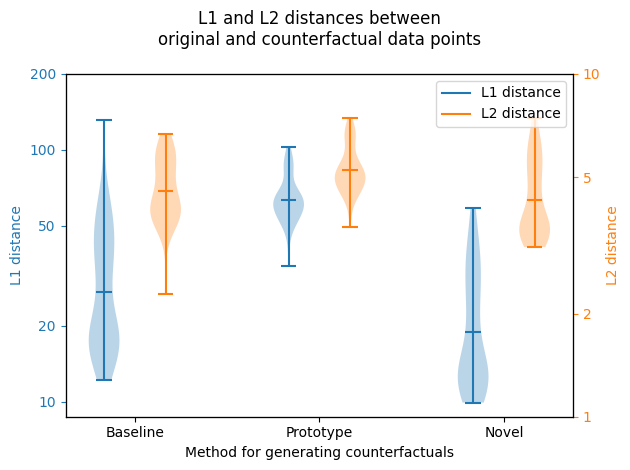

In [40]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.violinplot(
    [
        np.log(np.array(baseline_L1_distances)),
        np.log(np.array(prototype_L1_distances)),
        np.log(np.array(novel_L1_distances)),
    ],
    showmeans=True,
    positions=[1, 4, 7],
)
ax1.set_xticks([1.5, 4.5, 7.5], ["Baseline", "Prototype", "Novel"])
ax1.set_yticks(np.log(np.array([10, 20, 50, 100, 200])), [10, 20, 50, 100, 200])

ax2.plot([], [])
ax2.violinplot(
    [
        np.log(np.array(baseline_L2_distances)),
        np.log(np.array(prototype_L2_distances)),
        np.log(np.array(novel_L2_distances)),
    ],
    showmeans=True,
    positions=[2, 5, 8],
)
ax2.set_yticks(np.log(np.array([1, 2, 5, 10])), [1, 2, 5, 10])


ax1.set_ylabel("L1 distance")
ax1.yaxis.label.set_color("C0")
ax1.yaxis.set_tick_params(color="C0", labelcolor="C0")

ax2.set_ylabel("L2 distance")
ax2.yaxis.label.set_color("C1")
ax2.yaxis.set_tick_params(color="C1", labelcolor="C1")

ax3 = ax1.twinx()
ax3.plot([], [], label="L1 distance", color="C0")
ax3.plot([], [], label="L2 distance", color="C1")

ax1.set_xlabel("Method for generating counterfactuals")

ax3.legend()
ax3.set_yticks([])

plt.title("L1 and L2 distances between\noriginal and counterfactual data points\n")
plt.tight_layout()

plt.savefig("../../figures/counterfactual_distances.pdf")

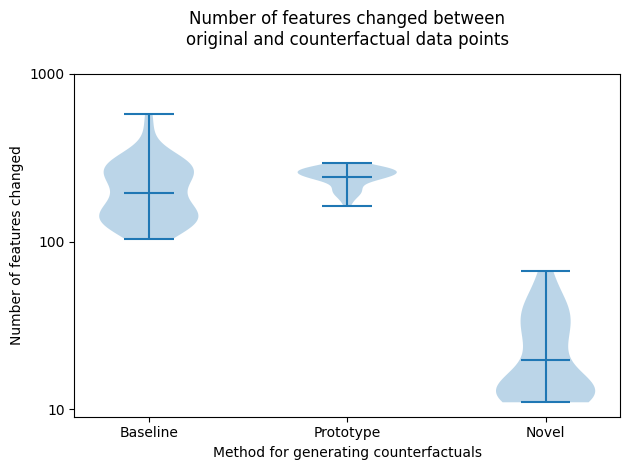

In [35]:
plt.violinplot(
    [
        np.log(np.array(baseline_features_changed)),
        np.log(np.array(prototype_features_changed)),
        np.log(np.array(novel_features_changed)),
    ],
    showmeans=True,
)

plt.xticks([1, 2, 3], ["Baseline", "Prototype", "Novel"])
plt.yticks(np.log(np.array([10, 100, 1000])), [10, 100, 1000])
plt.ylabel("Number of features changed")
plt.xlabel("Method for generating counterfactuals")
plt.title(
    "Number of features changed between\noriginal and counterfactual data points\n"
)
plt.tight_layout()
plt.savefig("../../figures/counterfactual_features_changed.pdf")